# Fine-Tuning of a base ViT

In [3]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [23]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
from medmnist import OCTMNIST, PathMNIST

In [34]:
train_dataset = OCTMNIST(split="train", download=True)

In [35]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, array([0]))

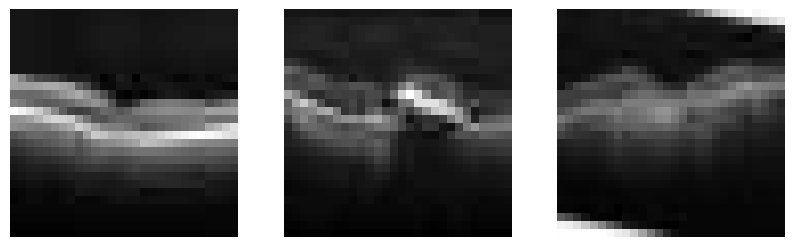

In [47]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

rows, cols = 1, 3
figure = plt.figure(figsize=(10, 10))
for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]

    img_tensor = transforms.ToTensor()(img)

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img_tensor.squeeze(), cmap="gray")

plt.show()

In [31]:
from medmnist import INFO, Evaluator

pathmnist_info = INFO["octmnist"]
labels = pathmnist_info["label"]

pathmnist_info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'url_224': 'https://zenodo.org/records/10519652/files/octmnist_224.npz?downl

In [51]:
test_image = train_dataset[0][0]

test_image = test_image.convert('RGB')

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=test_image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: nematode, nematode worm, roundworm


Unsure if we need to apply `.convert('RGB')` or if there exist another way to use OCTMNIST images in the ViT model, because the model expects dimensions of images to be 3, but since OCTMNIST have grayscaled images, the dimension is 2.

# Data Preparation

currently testing for pathmnist images since they already have images of 3 dimensions

In [94]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = PathMNIST(split="train", transform=data_transform, download=True)
test_dataset = PathMNIST(split="test", transform=data_transform, download=True)
val_dataset = PathMNIST(split="val", transform=data_transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64, 1])
Label: tensor([6])


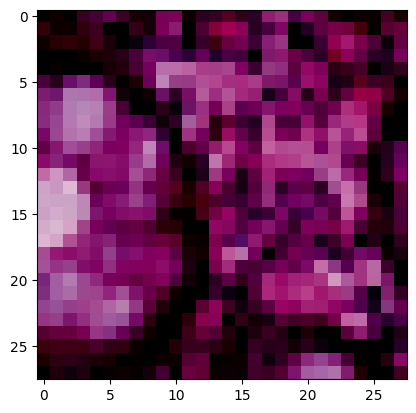

In [88]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label = train_labels[0]
print(f"Label: {label}")


img = train_features[0].squeeze().permute(1,2,0)
plt.imshow(img)
plt.show()


In [ ]:
# Potential image normalization (same setup as preprocessing steps in ViT article)
# (e.g. reshape image to 224 x 224, or also keep the images 28x28 but change ViT shape to 28x28 instead)

In [ ]:
# Configure dataloaders/datasets to be in supported format for fine-tuning (fix error in trainer)

# Fine-Tuning

In [90]:
from transformers import TrainingArguments, Trainer

trainig_arguments = TrainingArguments(
    learning_rate = 3e-5,
    lr_scheduler_type="cosine",
    num_train_epochs=2,
    #fp16=True, # Try this or bf16 in case fine-tuning takes too much time
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_ratio = 0.2,
    save_strategy="epoch"

)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [77]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [95]:
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

train_results = trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TypeError: vars() argument must have __dict__ attribute